In [1]:
import igraph as ig
import leidenalg as la
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
project = 'JHotDraw'
# 'JHotDraw', 'JEdit', 'SweetHome3D', 'BitcoinWallet', 'K9Mail'
prjfile = project.lower()

In [3]:
nodes = pd.read_csv(f"{prjfile}-nodes.csv")
edges = pd.read_csv(f"{prjfile}-edges.csv")

n = nodes.shape[0]

nodes.shape, edges.shape

((155, 4), (1156, 4))

In [4]:
import os
from os.path import exists

if (exists(f"{prjfile}-rolestereotypes.csv")):
  stypes = pd.read_csv(f"{prjfile}-rolestereotypes.csv")
  dc = [c for c in stypes.columns if c not in ['id','roleStereotype']]

  stypes.drop(columns=dc, inplace=True)
  nodes = pd.merge(nodes, stypes, on='id', how='left')
  
nodes

,id,name,package,type,roleStereotype
0,CH.ifa.draw.applet.DrawApplet,DrawApplet,CH.ifa.draw.applet,Structure,Service Provider
1,CH.ifa.draw.applet.SleeperThread,SleeperThread,CH.ifa.draw.applet,Structure,NaN
2,CH.ifa.draw.application.DrawApplication,DrawApplication,CH.ifa.draw.application,Structure,Information Holder
3,CH.ifa.draw.contrib.ChopPolygonConnector,ChopPolygonConnector,CH.ifa.draw.contrib,Structure,Service Provider
4,CH.ifa.draw.contrib.DiamondFigure,DiamondFigure,CH.ifa.draw.contrib,Structure,Service Provider
...,...,...,...,...,...
150,CH.ifa.draw.util.PaletteListener,PaletteListener,CH.ifa.draw.util,Structure,Service Provider
151,CH.ifa.draw.util.ReverseVectorEnumerator,ReverseVectorEnumerator,CH.ifa.draw.util,Structure,Information Holder
152,CH.ifa.draw.util.Storable,Storable,CH.ifa.draw.util,Structure,Service Provider
153,CH.ifa.draw.util.StorableInput,StorableInput,CH.ifa.draw.util,Structure,Service Provider


In [5]:
g = ig.Graph(n=n, directed=True)
print(g)

IGRAPH D--- 155 0 --


In [6]:
for c in nodes.columns:
  g.vs[c] = nodes[c]

g['name'] = project
g.vs["label"] = g.vs["name"]

print(g)

IGRAPH DN-T 155 0 -- JHotDraw
+ attr: name (g), id (v), label (v), name (v), package (v), type (v)


In [7]:
def indexById(graph, id):
  '''Get node index by id.'''
  return graph.vs.find(id_eq=id).index


accepts
constructs
depends
holds
returns
specializes


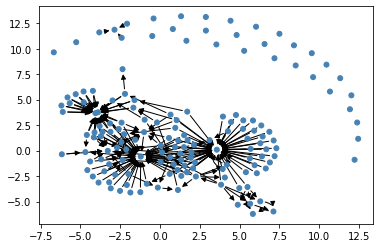

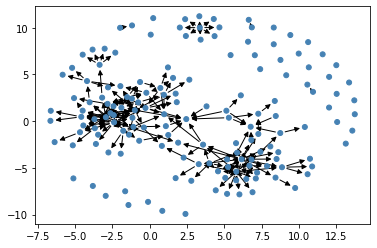

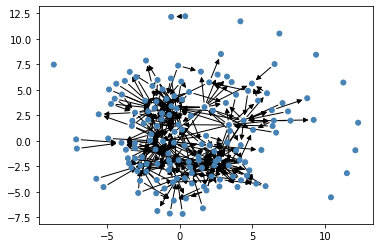

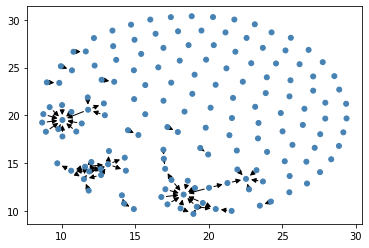

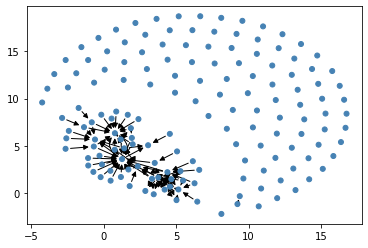

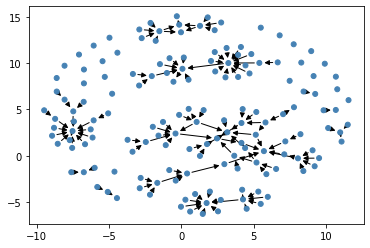

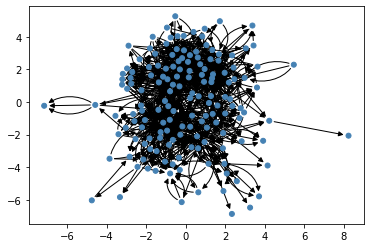

In [8]:
grouped = edges.groupby('interaction')

gl = dict()
for name, group in grouped:
  gl[name] = g.copy()
  gl[name]['name'] = f"{project}-{name}"
  
  es = [(indexById(gl[name], row['source']), indexById(gl[name], row['target'])) for row in group.to_dict('records')]
  gl[name].add_edges(es) 
  
  for c in group.columns:
    gl[name].es[c] = group[c].to_list()

  print(name)
  fig, ax = plt.subplots()
  ig.plot(gl[name], bbox=(1000, 1000), margin=20, target=ax)

es = [(indexById(g, row['source']), indexById(g, row['target'])) for row in edges.to_dict('records')]
g.add_edges(es) 

for c in edges.columns:
  g.es[c] = edges[c].to_list()

fig, ax = plt.subplots()
ig.plot(g, bbox=(1000, 100), margin=20, target=ax)

In [9]:
optimiser = la.Optimiser()

membership, improv = la.find_partition_multiplex(
                       list(gl.values()),
                       la.ModularityVertexPartition);

g.vs['mpx_membership'] = membership
nodes['mpx_membership'] = membership

print(membership)

[0, 0, 0, 1, 2, 2, 2, 4, 2, 2, 4, 1, 2, 3, 5, 1, 5, 1, 1, 2, 2, 2, 4, 0, 3, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 4, 2, 4, 1, 1, 2, 5, 0, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 4, 2, 0, 0, 0, 3, 5, 3, 0, 5, 5, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 4, 2, 0, 0, 0, 4, 0, 0, 0, 1, 1, 1, 1, 3, 1, 1, 0, 3, 0, 3, 0, 3, 0, 4, 3, 3, 0, 0, 4, 2, 4, 4, 4, 4, 2, 2, 0, 2, 3, 0, 0, 0, 0, 4, 4, 4, 3, 0, 5, 0, 0, 4, 5, 0, 2, 2, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 3, 2, 2, 2]


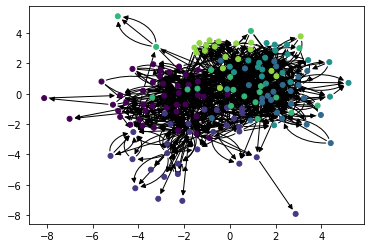

In [10]:
partition = la.find_partition(g, la.ModularityVertexPartition, weights='weight', seed=42)
fig,ax = plt.subplots()
ig.plot(partition, bbox=(1000, 100), margin=20, target=ax)

# print(partition)

In [11]:
g.vs['single_membership'] = partition.membership
nodes['single_membership'] = partition.membership

In [12]:
g.write_graphml(f"{prjfile}.graphml")

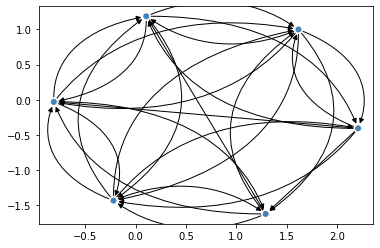

In [13]:
cg = partition.cluster_graph()

fig,ax = plt.subplots()
ig.plot(cg, bbox=(1000, 100), margin=20, target=ax)

In [14]:
print(cg)

IGRAPH D--- 6 27 -- JHotDraw
+ attr: name (g)
+ edges:
0 -> 1 2 3 4     2 -> 0 1 3 4 5   4 -> 0 1 2 3 5
1 -> 0 2 3 4 5   3 -> 0 2 4 5     5 -> 0 2 3 4


In [15]:
nodes

,id,name,package,type,mpx_membership,single_membership
0,CH.ifa.draw.applet.DrawApplet,DrawApplet,CH.ifa.draw.applet,Structure,0,1
1,CH.ifa.draw.applet.SleeperThread,SleeperThread,CH.ifa.draw.applet,Structure,0,1
2,CH.ifa.draw.application.DrawApplication,DrawApplication,CH.ifa.draw.application,Structure,0,1
3,CH.ifa.draw.contrib.ChopPolygonConnector,ChopPolygonConnector,CH.ifa.draw.contrib,Structure,1,5
4,CH.ifa.draw.contrib.DiamondFigure,DiamondFigure,CH.ifa.draw.contrib,Structure,2,2
...,...,...,...,...,...,...
150,CH.ifa.draw.util.PaletteListener,PaletteListener,CH.ifa.draw.util,Structure,0,1
151,CH.ifa.draw.util.ReverseVectorEnumerator,ReverseVectorEnumerator,CH.ifa.draw.util,Structure,3,4
152,CH.ifa.draw.util.Storable,Storable,CH.ifa.draw.util,Structure,2,2
153,CH.ifa.draw.util.StorableInput,StorableInput,CH.ifa.draw.util,Structure,2,2


In [16]:
nodes['id']

0                 CH.ifa.draw.applet.DrawApplet
1              CH.ifa.draw.applet.SleeperThread
2       CH.ifa.draw.application.DrawApplication
3      CH.ifa.draw.contrib.ChopPolygonConnector
4             CH.ifa.draw.contrib.DiamondFigure
                         ...                   
150            CH.ifa.draw.util.PaletteListener
151    CH.ifa.draw.util.ReverseVectorEnumerator
152                   CH.ifa.draw.util.Storable
153              CH.ifa.draw.util.StorableInput
154             CH.ifa.draw.util.StorableOutput
Name: id, Length: 155, dtype: object

In [17]:
from collections import Counter
import re

components = []
for group, data in nodes.groupby('mpx_membership'):
  c = { 'id': group, 'members': set(data['id']), 'member_names': ' '.join(data['name']) }
  c['name'] = '-'.join([name for name, _ in Counter(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', c['member_names'])).most_common(3)])
  c['words'] = ' '.join(re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', c['member_names']))
  components.append(c)

cdf = pd.DataFrame(components)

cdf

,id,members,member_names,name,words
0,0,"{CH.ifa.draw.applet.DrawApplet, CH.ifa.draw.fr...",DrawApplet SleeperThread DrawApplication Group...,Command-Tool-Drawing,Draw Applet Sleeper Thread Draw Application Gr...
1,1,"{CH.ifa.draw.standard.AbstractConnector, CH.if...",ChopPolygonConnector ArrowTip ChopEllipseConne...,Connection-Connector-Line,Chop Polygon Connector Arrow Tip Chop Ellipse ...
2,2,"{CH.ifa.draw.util.StorableOutput, CH.ifa.draw....",DiamondFigure PolygonFigure PolygonHandle Poly...,Figure-Locator-Polygon,Diamond Figure Polygon Figure Polygon Handle P...
3,3,{CH.ifa.draw.samples.javadraw.AnimationDecorat...,BorderDecorator GroupFigure Figure FigureChang...,Figure-Decorator-Change,Border Decorator Group Figure Figure Figure Ch...
4,4,"{CH.ifa.draw.standard.SouthEastHandle, CH.ifa....",PolygonScaleHandle TriangleRotationHandle Font...,Handle-East-North,Polygon Scale Handle Triangle Rotation Handle ...
5,5,"{CH.ifa.draw.samples.javadraw.URLTool, CH.ifa....",BorderTool ConnectedTextTool TextTool Animator...,Tool-Text-Java,Border Tool Connected Text Tool Text Tool Anim...
